# Analyzing Ford's GoBike Data
## by Dishant Tanwar

## Investigation Overview

> In this investigation, we'll be taking a look at the data set provided by Ford's GoBike for year 2019. We'll be asking questions to understand how Ford's GoBikes are being used by people, what trends does it follow.

## Dataset Overview
> The dataset is provided by Ford's GoBike themselves. You can get the dataset from <a href='https://www.lyft.com/bikes/bay-wheels/system-data'>here</a>.

The dataset contains the below mentioned variables.  
- Trip Duration (seconds)
- Start Time and Date
- End Time and Date
- Start Station ID
- Start Station Name
- Start Station Latitude
- Start Station Longitude
- End Station ID
- End Station Name
- End Station Latitude
- End Station Longitude
- Bike ID
- User Type (Subscriber or Customer – “Subscriber” = Member or “Customer” = Casual)


In [2]:
# import all packages and set plots to be embedded inline
import matplotlib.pyplot as plt

from zipfile import ZipFile
from io import BytesIO

import numpy as np
import pandas as pd
import seaborn as sns

import requests
import time
import os

%matplotlib inline

# suppress warnings from final output
import warnings
warnings.simplefilter("ignore")

In [3]:
# load in the dataset into a pandas dataframe
df = pd.read_csv('ford-go-bike-master.csv')

In [4]:
# Changing suitable datatypes
df['start_time'] = pd.to_datetime(df['start_time'])
df['end_time'] = pd.to_datetime(df['end_time'])

df['start_station_id'] = df['start_station_id'].astype('str')
df['end_station_id'] = df['end_station_id'].astype('str')
df['bike_id'] = df['bike_id'].astype('str')

df['user_type'] = df['user_type'].astype('category')

weekday = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekday_cat = pd.api.types.CategoricalDtype(ordered = True, categories = weekday)
df['weekday'] = df['weekday'].astype(weekday_cat)

months = df.month.unique()
months_cat = pd.api.types.CategoricalDtype(ordered = True, categories = months) 
df['month'] = df['month'].astype(months_cat)


df.day.astype('str', inplace = True)
df.hour.astype('str', inplace = True)
print('Done')

Done


## Proportion of Users

> We've Subscribers and Customers as user types. Where the number of subcribers is about four times the number of customers. Subscribers are the membership holders whereas Customers are Casal Users.

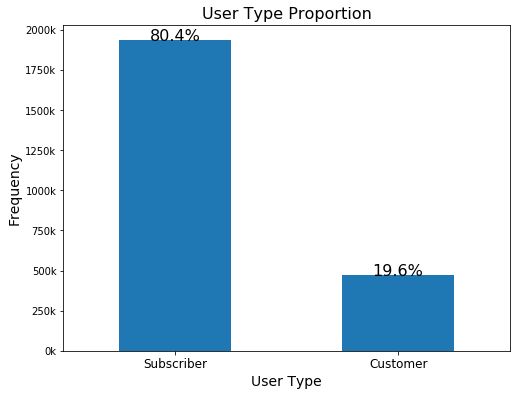

In [13]:
base_color = sns.color_palette()[0]
plt.figure(figsize = (8,6))
df.user_type.value_counts().plot(kind='bar', color = base_color)
ax = plt.subplot()
y_ticklabels = [(str(i) + 'k') for i in np.arange(0, 2250, 250) ] 
plt.title('User Type Proportion', fontsize = 16);
plt.ylabel('Frequency', fontsize = 14)
plt.xlabel('User Type', fontsize=14)
plt.xticks(rotation=0, fontsize=12)
ax.set_yticklabels(y_ticklabels)
# add annotations
n_points = df.shape[0]
cat_counts = df['user_type'].value_counts()
locs, labels = plt.xticks() # get thze current tick locations and labels

# loop through each pair of locations and labels
for loc, label in zip(locs, labels):

    # get the text property for the label to get the correct count
    count = cat_counts[label.get_text()]
    pct_string = '{:0.1f}%'.format(100*count/n_points)

    # print the annotation just below the top of the bar
    plt.text(loc, count-8, pct_string, ha = 'center', color = 'black', fontsize=16)

## Duration of Bike Trips (minutes)
> Most of the trips have a duration of 7-14 minutes. 

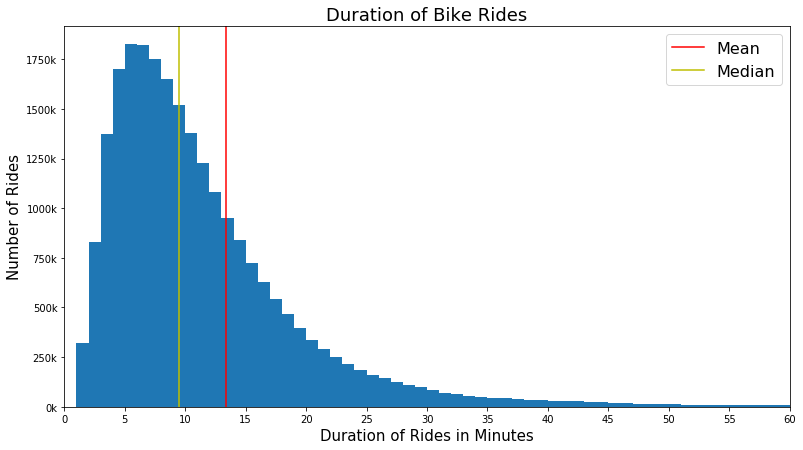

In [19]:
plt.figure(figsize=(13,7))
ax = plt.subplot()
y_ticklabels = [(str(i) + 'k') for i in np.arange(0, 2250, 250) ] 

bins = np.arange(0, df.duration_mins.max() + 1, 1)
plt.hist(data = df, x = 'duration_mins', bins = bins);
plt.xlim(0,60);
plt.xticks(np.arange(0, 65, 5))
ax.set_yticklabels(y_ticklabels)

plt.axvline(df.duration_mins.mean(), color = 'r', label = 'Mean')
plt.axvline(df.duration_mins.median(), color = 'y', label = 'Median')
plt.legend(fontsize = 16)


plt.title('Duration of Bike Rides', fontsize = 18);
plt.xlabel('Duration of Rides in Minutes', fontsize = 15);
plt.ylabel('Number of Rides', fontsize = 15);

## Monthly Trip Duration per User Type
> Even though Subscribers or Members are consistent ride users but the Customers or Non members have a longer trip duration.  Also during winter the Non-member group's usage of bikes starts decreasing and is at it's lowest during December.

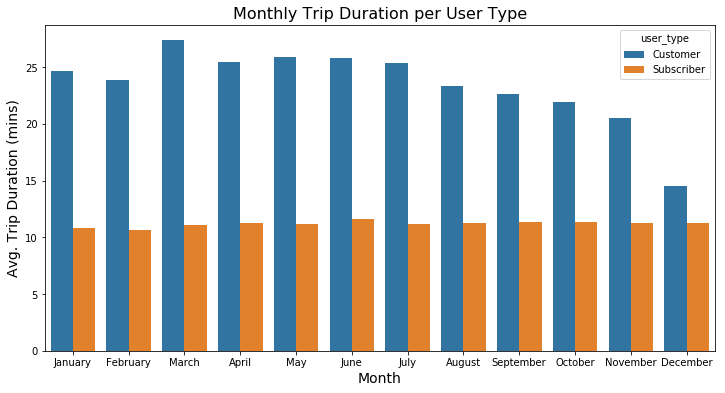

In [21]:
hr_ut_dur = df.groupby(['user_type','month']).duration_mins.mean().reset_index()

plt.figure(figsize=(12,6))
sns.barplot(data = hr_ut_dur, x='month', y='duration_mins' ,hue='user_type');
plt.xlabel('Month', fontsize=14);
plt.ylabel('Avg. Trip Duration (mins)', fontsize=14);
plt.title('Monthly Trip Duration per User Type', fontsize=16);

## Weekly Trip Duration per User Type
> During weekends for Subscribers the average trip duration increases by around 2 minutes. But for Customer or Non-member users it increases by around 7 minutes.

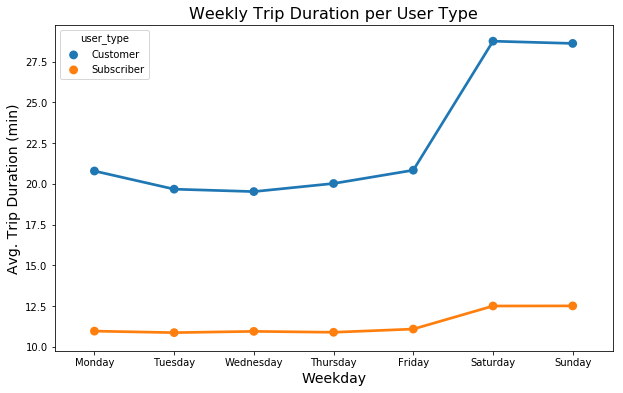

In [23]:
hr_ut_dur = df.groupby(['user_type','weekday']).duration_mins.mean().reset_index()
hr_ut_dur = hr_ut_dur.query('duration_mins < 600')
plt.figure(figsize=(10,6))
sns.pointplot(data = hr_ut_dur, x='weekday', y='duration_mins' ,hue='user_type');
plt.xlabel('Weekday', fontsize=14);
plt.ylabel('Avg. Trip Duration (min)', fontsize=14);
plt.title('Weekly Trip Duration per User Type', fontsize=16);

## Hourly Usage during Weekdays for Customers and Subscribers

**During Work Days**
- In terms of count, the bike ride usage is seen at its peak during morning and evening hours, at 8 am and 5pm. Which is something we were expecting as these are the work times when people leave for their workplaces at around 8 in the morning and from work to home at around 5 pm. 
- This trend is seen for both user types. Also, unlike Member types the Customer or non member types, have shown increased usage between 1 pm and 2 pm.  

**During Weekends**
- During Weekends, the peak usage is seen between 12 noon and 4 pm.

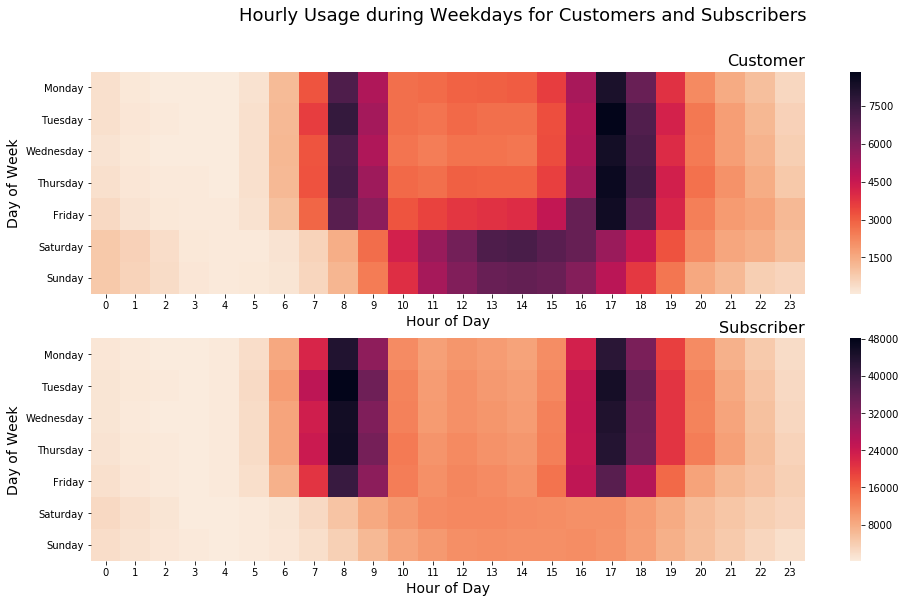

In [22]:
plt.figure(figsize = (16,9))
plt.suptitle('Hourly Usage during Weekdays for Customers and Subscribers', fontsize = 18)

plt.subplot(2, 1, 1)
customers = df.query('user_type == "Customer"')
ct_counts = customers.groupby(['weekday', 'hour']).size()
ct_counts = ct_counts.reset_index(name='count')
ct_counts = ct_counts.pivot(index='weekday', columns='hour', values='count')
sns.heatmap(ct_counts, cmap='rocket_r');
plt.title('Customer', loc='right', fontsize = 16);
plt.xlabel('Hour of Day', fontsize = 14);
plt.ylabel('Day of Week', fontsize = 14);

plt.subplot(2, 1, 2)
subscribers = df.query('user_type == "Subscriber"')
st_counts = subscribers.groupby(['weekday', 'hour']).size()
st_counts = st_counts.reset_index(name='count')
st_counts = st_counts.pivot(index='weekday', columns='hour', values='count')
sns.heatmap(st_counts, cmap='rocket_r');
plt.title('Subscriber', loc='right', fontsize = 16);
plt.xlabel('Hour of Day', fontsize = 14);
plt.ylabel('Day of Week', fontsize = 14);